In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
%matplotlib inline

from datetime import date
from datetime import timedelta
import zipfile
import os
import requests

import numpy as np
import cv2

!pip install geopy
import geopy.distance
!pip install geopandas
import geopandas  as gpd
from shapely.geometry import Point, LineString, Polygon


# Import specific function 'from_epsg' from fiona module
from fiona.crs import from_epsg

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 118 kB 6.1 MB/s            
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 994 kB 7.7 MB/s            
     |████████████████████████████████| 16.6 MB 66.7 MB/s            
     |████████████████████████████████| 2.0 MB 65.4 MB/s            
     |████████████████████████████████| 6.5 MB 40.5 MB/s            


In [169]:
import random

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import math

In [ ]:
# connect to google drive
from google.colab import drive  

# drive roots
DRIVE_MOUNT = '/content/drive'
drive.mount(DRIVE_MOUNT, force_remount=True)

# set up project directories
PROJECT_DIR = DRIVE_MOUNT + "/My Drive/Volcano_datasets/"
TMP_DIR = PROJECT_DIR + "TempDIR/"
targets = pd.read_excel(PROJECT_DIR + "Sample Eruptions.xlsx")

OUTPUT_SHAPE_DIR = PROJECT_DIR+"output_damage_shapes/"

In [16]:
dist=5
geopy.distance.distance(kilometers=(dist - ((dist/2) * np.random.rand()))).destination((50, 20), bearing=200)[:2]

(49.964930835073, 19.980213080821123)

In [14]:
(dist - ((dist/2) * np.random.rand()))

4.232114539828983

# Making Damage Shapefiles

- The layer column can be encoded to be a damage layer value (e.g. could encode 999 to mean high damage, 99 as medium damange, and 9 as no damage or just have only high+med damage layers)
- Given the input will be a blocky image with damage zones indicates by single values, the general approach can be:
    1. We know the lat/long of each volcano so we can calculate where each block is located given that 1 pixel=30m (center = 375x375 pixel)
        - Start from the top left block (center at 25x25)
        - Check if the block is high, medium, or no damage
        - If high or medium damage:
            - Calculate how far the center of that block is from the center of the volcano image in meters 
            - Generate shapefiles in 360 degrees that extend up to 25px (750m)
        - else if no damage:
            - no need to generate a shapefile and will assume to use google earth engine's default layer
        - Continue iterating for each block in the entire image 
 

In [4]:
image = cv2.imread('test_bucketized_damage.png', cv2.COLOR_BGR2GRAY )

In [283]:
targets = pd.read_csv('Sample Eruptions.csv')

In [294]:
def get_meter_distance(x1, y1, x2=375, y2=375):
    '''Return hypotenuse distance in meters between two pixel centers of blocks assuming 1 pixel = 30 m'''
    a = abs(x1-x2)
    b = abs(y1-y2)
    return math.sqrt(a**2 + b**2)*30

def get_damage_type(pixel):
    if pixel == 255:
        return 'high'
    elif pixel== 100:
        return 'med'
    else:
        return 'low'
    

def get_quadrant_subtractor(x1, y1):
    '''Selecting quadrant based on image coordinates'''
    if x1>=375 and y1<=375: # first quadrant
        return 90
    elif x1>=375 and y1>=375: # second quadrant
        return 180
    elif x1<=375 and y1>=375: # third quadrant
        return 270
    else:
        return 360
    
def get_bearing(x1, y1, x2=375, y2=375):
    '''Tutorial here - https://mathsathome.com/calculating-bearings/
    Geopy radians takes degrees, so will convert to degrees at the end
    '''
    a = abs(x1-x2)
    b = abs(y1-y2)
#     print(f"x-val: {a}, y-val:{b}")
    if a==0:
        return 0
    angle = math.atan(b/a)

    bearing = get_quadrant_subtractor(x1, y1) - math.degrees(angle)
    return bearing

def get_lat_long(distance, bearing, lat, lon):
    '''get the latitude and longitude of the bucketed damage point center to be used as the new center to generate shapefiles
    
    distance -> distance in meters
    bearing -> bearing in degrees
    lat -> latitude of original point in degrees
    lon -> longitude of original point in degrees
    
    '''
    R = 6378.1 #Radius of the Earth
    brng = math.radians(bearing) #Bearing is 90 degrees converted to radians.
    d = distance/1000 #Distance in km

    #lat2  52.20444 - the lat result I'm hoping for
    #lon2  0.36056 - the long result I'm hoping for.

    lat1 = math.radians(lat) #Current lat point converted to radians
    lon1 = math.radians(lon) #Current long point converted to radians

    lat2 = math.asin( math.sin(lat1)*math.cos(d/R) +
         math.cos(lat1)*math.sin(d/R)*math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(lat1),
                 math.cos(d/R)-math.sin(lat1)*math.sin(lat2))

    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    return lat2, lon2

In [ ]:
# example image is Sinabung with lat/long = 3.17,98.392

In [288]:
def get_polygon(lat, lon, point_bearing):
    pts = []
    # base the bearing on the direction the block point is from the center point
    # 50% chance for values in the same bearing area and 50% for bearings in other quadrants 
    bearings = []
    num_bearings = 20
    if point_bearing <= 90: # first quadrant
        # higher probability for a bearing in the 0-180 range
        bearings = random.choices(range(0, 360, 10), weights= [.06]*9 + [0.017037037037037035]*27, k=num_bearings)
    elif point_bearing <=180:
        bearings = random.choices(range(0, 360, 10), weights= [0.017037037037037035]*9 + [.06]*9 + [0.017037037037037035]*18, k=num_bearings)
    elif point_bearing <= 270:
        bearings = random.choices(range(0, 360, 10), weights= [0.017037037037037035]*18 + [.06]*9 + [0.017037037037037035]*9, k=num_bearings)
    else:
        bearings = random.choices(range(0, 360, 10), weights= [0.017037037037037035]*27 + [.06]*9, k=num_bearings)
        
#     for bearing in range(0,360,10):
    for bearing in sorted(bearings):
         #calculate random meter distance to head to based on 1 to 25 pixels (block size)
        rand_dist = np.random.choice(range(100, 751, 1))
        pt =  geopy.distance.distance(meters=rand_dist)\
                    .destination((lat, lon), bearing=bearing)[:2] # go the calculated distance based on the volcano distance and bearing (angle)
        pts.append([pt[1],pt[0]])
        
    return Polygon(pts)

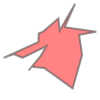

In [289]:
get_polygon(3.17, 98.392, 270)

In [56]:
def generate(image, start_lat, start_lon):
    '''Generate the Shapefile Polygon for the difference of difference damage file'''
    
    

(3.17004521708239, 98.39192208518631)

In [295]:
kernel=50
iterations = image.shape[1] / kernel
image_len = image.shape[1]
copy = image.copy()
sinabung_lat = 3.17
sinabung_lon = 98.392
polygons = []
for row in range(25, image_len, kernel):
    for col in range(25, image_len, kernel):
#         block_center = copy[row:row+kernel, col:col+kernel]
#         print(f"{row}:{col}")
        if get_damage_type(image[row, col]) != 'low':
            meters = get_meter_distance(row, col)
            bearing = get_bearing(row, col)
            lat, lon = get_lat_long(meters, bearing, sinabung_lat, sinabung_lon)
            polygon = get_polygon(lat, lon, bearing)
            polygons.append(polygon)

In [299]:
len(polygons)

44

In [ ]:
# distances = [1,5,100,500,1000]
newdata = gpd.GeoDataFrame()
id = 0
for ivol in range(targets.shape[0]):
    volc = targets.iloc[ivol]
    vloc = Point( volc["Longitude"],volc["Latitude"])
    v_name = re.sub(r"[,.]","",re.sub(r"\s+", "_",volc["Volcano Name"]))
    erupt_start_date = date(volc["Start Year"].astype(int),
                            volc["Start Month"].astype(int),
                            volc["Start Day"].astype(int))
  

    newdata.loc[id,'geometry'] = get_polygon(volc["Latitude"], volc["Longitude"])
    newdata.loc[id,"Volc_Name"] = v_name
    newdata.loc[id,"Volc_Num"] = volc["Volcano Number"]
    newdata.loc[id,"Erupt_Num"] = volc["Eruption Number"]
    newdata.loc[id,"Est_Date"] = erupt_start_date.isoformat()
    newdata.loc[id,"layer"] = dist
    id = id +1
    
print(newdata)
newdata.set_crs('EPSG:3857')
output_file = f'{OUTPUT_SHAPE_DIR}/all_data.shp'
newdata.to_file(output_file)

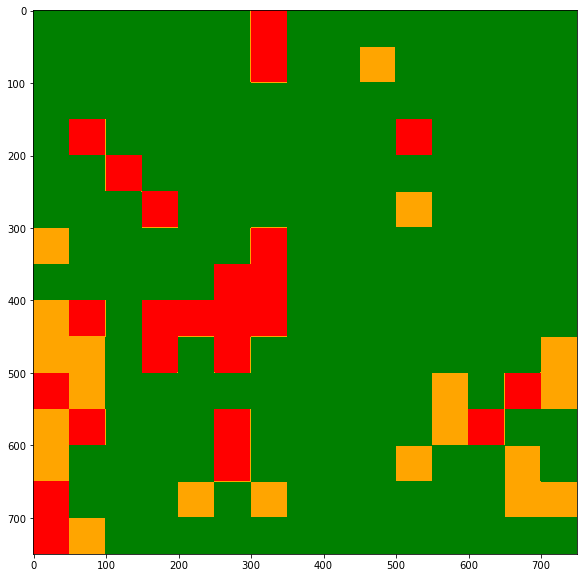

In [9]:
cmap = colors.ListedColormap(['green','orange', 'red'])
bounds=[0,100,255]
plt.figure(figsize=(20, 10))
plt.imshow(image, cmap=cmap)

(0,0) = (375, 375)    left = normal, right = image
subtract 375 from every x and add 375 to every y

In [ ]:
distances = [1,5,100,500,1000]
newdata = gpd.GeoDataFrame()
id = 0
for ivol in range(targets.shape[0]):
    volc = targets.iloc[ivol]
    vloc = Point( volc["Longitude"],volc["Latitude"])
    v_name = re.sub(r"[,.]","",re.sub(r"\s+", "_",volc["Volcano Name"]))
    erupt_start_date = date(volc["Start Year"].astype(int),
                            volc["Start Month"].astype(int),
                            volc["Start Day"].astype(int))
  
  for dist in distances:
    pts = []
    for bearing in range(0,350,10):
        pt =  geopy.distance.distance(kilometers=(dist - ((dist/2) * np.random.rand())))\ #calculate random KM distance to head to
                   .destination((volc["Latitude"], volc["Longitude"]), bearing=bearing)[:2] # go the calculated distance based on the volcano distance and bearing (angle)
        pts.append([pt[1],pt[0]])
    poly = Polygon(pts)
    newdata.loc[id,'geometry'] = poly
    newdata.loc[id,"Volc_Name"] = v_name
    newdata.loc[id,"Volc_Num"] = volc["Volcano Number"]
    newdata.loc[id,"Erupt_Num"] = volc["Eruption Number"]
    newdata.loc[id,"Est_Date"] = erupt_start_date.isoformat()
    newdata.loc[id,"layer"] = dist
    id = id +1
    
print(newdata)
newdata.set_crs('EPSG:3857')
output_file = f'{OUTPUT_SHAPE_DIR}/all_data.shp'
newdata.to_file(output_file)

                                              geometry         Volc_Name  \
0    POLYGON ((130.21700 30.44909, 130.21869 30.451...  Kuchinoerabujima   
1    POLYGON ((130.21700 30.48262, 130.22451 30.479...  Kuchinoerabujima   
2    POLYGON ((130.21700 31.00062, 130.32443 30.968...  Kuchinoerabujima   
3    POLYGON ((130.21700 33.50320, 131.13979 34.764...  Kuchinoerabujima   
4    POLYGON ((130.21700 36.38784, 131.28065 35.386...  Kuchinoerabujima   
..                                                 ...               ...   
130  POLYGON ((157.97900 -8.98520, 157.97982 -8.986...           Kavachi   
131  POLYGON ((157.97900 -8.96580, 157.98307 -8.968...           Kavachi   
132  POLYGON ((157.97900 -8.27949, 158.06318 -8.515...           Kavachi   
133  POLYGON ((157.97900 -6.35922, 158.42619 -6.453...           Kavachi   
134  POLYGON ((157.97900 -4.11519, 159.35471 -1.112...           Kavachi   

     Volc_Num  Erupt_Num    Est_Date   layer  
0    282050.0    22345.0  2020-01-11    